# Dataset and Benchmark creation with `Polaris`
The first step of creating a benchmark is to set up a standard dataset which allows accessing the curated dataset (which has been demonstrated in <01_polaris_adme-fang-1_data_curation.ipynb>), and all necessary information about the dataset such as data source, description of endpoints, units etc. 

The resulting benchmarks can be found in Polaris:
- [polaris/adme-fang-hclint-1](https://polarishub.io/benchmarks/polaris/adme-fang-hclint-1)
- [polaris/adme-fang-rclint-1](https://polarishub.io/benchmarks/polaris/adme-fang-rclint-1)
- [polaris/adme-fang-perm-1](https://polarishub.io/benchmarks/polaris/adme-fang-perm-1)
- [polaris/adme-fang-hppb-1](https://polarishub.io/benchmarks/polaris/adme-fang-hppb-1)
- [polaris/adme-fang-rppb-1](https://polarishub.io/benchmarks/polaris/adme-fang-rppb-1)
- [polaris/adme-fang-solu-1](https://polarishub.io/benchmarks/polaris/adme-fang-solu-1)
- [polaris/adme-fang-r-1](https://polarishub.io/benchmarks/polaris/adme-fang-r-1)

In [1]:
%load_ext autoreload
%autoreload 2
import os
import pathlib
import warnings
import pandas as pd
import datamol as dm
import numpy as np

from sklearn.model_selection import ShuffleSplit
import polaris

# polaris curation module
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID

# polaris dataset
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.dataset._column import Modality

# polaris benchmark
from polaris.benchmark import (
    SingleTaskBenchmarkSpecification,
    MultiTaskBenchmarkSpecification,
)
from polaris.utils.types import HubOwner, License

os.chdir(pathlib.Path("__file__").absolute().parents[1])

from utils import display_chemspace, load_readme, save_figure

In [2]:
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner

HubOwner(slug='polaristest', external_id=None, type=None)

In [3]:
BENCHMARK_DIR = "gs://polaris-public/benchmarks/ADME/fang2023"
DATASET_DIR = "gs://polaris-public/datasets/ADME/fang2023"
FIGURE_DIR = "gs://polaris-public/datasets/ADME/fang2023/figures"

## Load existing data
> **Attention:** \
> The original dataset is published in [`Fang et al. 2023`](https://doi.org/10.1021/acs.jcim.3c00160). 
https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv \ \
> To **maintain consistency** with other benchmarks in the Polaris Hub, a thorough data curation process is carried out to ensure the accuracy of molecular presentations.
> Therefore, the raw data from the data resource is not used here. 
> See more curation details in [01_ADME_data_curation.ipynb](https://github.com/polaris-hub/polaris-recipes/blob/mvp/01_ADME/01_ADME_data_curation.ipynb)

In [4]:
# Load data
PATH = "gs://polaris-public/data/ADME/fang2023_public_set_3521_curated.csv"
table = pd.read_csv(PATH)

### Below we specify the meta information of data columns

In [5]:
# Here we simplify the column names
table = table.rename(
    columns={
        "molhash_id": "UNIQUE_ID",
        "LOG HLM_CLint (mL/min/kg)": "LOG_HLM_CLint",
        "LOG RLM_CLint (mL/min/kg)": "LOG_RLM_CLint",
        "LOG MDR1-MDCK ER (B-A/A-B)": "LOG_MDR1-MDCK_ER",
        "LOG PLASMA PROTEIN BINDING (HUMAN) (% unbound)": "LOG_HPPB",
        "LOG PLASMA PROTEIN BINDING (RAT) (% unbound)": "LOG_RPPB",
        "LOG SOLUBILITY PH 6.8 (ug/mL)": "LOG_SOLUBILITY",
    }
)

In [6]:
table.reset_index(drop=True, inplace=True)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecule structures and identifiers in the dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [7]:
annotations = {
    "UNIQUE_ID": ColumnAnnotation(
        description="Molecular hash ID. See <datamol.mol.hash_mol>"
    ),
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string after cleaning and standardization.",
        modality=Modality.MOLECULE,
    ),
    "ORIGINAL_SMILES": ColumnAnnotation(
        description="Original molecule SMILES string from the publication."
    ),
    "LOG_HLM_CLint": ColumnAnnotation(
        description="Human liver microsomal stability reported as intrinsic clearance",
        user_attributes={
            "unit": "mL/min/kg",
            "scale": "log",
            "organism": "human",
            "objective": "Higher value",
        },
    ),
    "LOG_RLM_CLint": ColumnAnnotation(
        description="Rat liver microsomal stability reported as intrinsic clearance",
        user_attributes={
            "unit": "mL/min/kg",
            "scale": "log",
            "organism": "rat",
            "objective": "Lower value",
        },
    ),
    "LOG_MDR1-MDCK_ER": ColumnAnnotation(
        description="MDR1-MDCK efflux ratio (B-A/A-B)",
        user_attributes={
            "unit": "mL/min/kg",
            "scale": "log",
            "objective": "Higher value",
        },
    ),
    "LOG_HPPB": ColumnAnnotation(
        description="Human plasma protein binding",
        user_attributes={"unit": "% unbound", "objective": "Lower value"},
    ),
    "LOG_RPPB": ColumnAnnotation(
        description="Rat plasma protein binding",
        user_attributes={"unit": "% unbound", "objective": "Lower value"},
    ),
    "LOG_SOLUBILITY": ColumnAnnotation(
        description="Solubility was measured after equilibrium between the dissolved and solid state",
        user_attributes={
            "unit": "ug/mL",
            "scale": "log",
            "PH": "6.8",
            "objective": "Higher value",
        },
    ),
}

### Define `Dataset` object

In [8]:
dataset_name = "adme-fang-1"

In [9]:
dataset = Dataset(
    table=table[annotations.keys()].copy(),
    name=dataset_name,
    description="A DMPK datasets of six ADME in vitro endpoints from fang et al. 2023. ",
    source="https://doi.org/10.1021/acs.jcim.3c00160",
    annotations=annotations,
    owner=owner,
    tags=["adme"],
    readme=load_readme(
        "gs://polaris-public/readme/datasets/fang2023_ADME_public_v1_readme.md"
    ),
    licence=License(id="CC-BY-4.0"),
)

In [10]:
# save the dataset
SAVE_DIR = f"{DATASET_DIR}/{dataset_name}"
dataset.to_json(SAVE_DIR)

'gs://polaris-public/datasets/ADME/fang2023/adme-fang-1/dataset.json'

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

## Single task training performance compare to the results from paper Fang2023 as baseline.
The tasks use the same test sets as in the fang2023 paper.
Here we create a single task benchmark for each the six ADME endpoints.
The test set was created based on the train and test split provided in https://github.com/molecularinformatics/Computational-ADME/tree/main/MPNN. \
The dataset is slightly different to the dataset published in Fang et al. 2023 after removing the undesired molecules in the context of small molecules.

In [11]:
# Specify names and extract the test set from their dataset
endpoints = {
    "HLM": "HLM_CLint",
    "RLM": "RLM_CLint",
    "hPPB": "HPPB",
    "rPPB": "RPPB",
    "MDR1_ER": "MDR1-MDCK_ER",
    "Sol": "SOLUBILITY",
}

_endpoint = list(endpoints.keys())
INDIR = "gs://polaris-public/Data/ADME/fang2023/MPNN"

<div class="alert alert-block alert-warning"> <b>Attention:</b> We have noticed a set of molecules which have activity in MPNN folder, have no values in the `https://github.com/molecularinformatics/Computational-ADME/blob/main/ADME_public_set_3521.csv` file. We exclude the these molecules from splits to avoid confusion.</div>

In [24]:
split_key = "fang2023split"
paper_splits = {}
for endpoint in _endpoint:
    trainset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_train.csv")
    testset = dm.read_csv(f"{INDIR}/ADME_{endpoint}_test.csv")
    train = table.query(f"`SMILES` in @trainset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() ").index.values
    test = table.query(f"`SMILES` in @testset.smiles  & `{'LOG_'+endpoints[endpoint]}`.notna() ").index.values

    # check the intersections:
    intersection = set(train).intersection(set(test))
    if len(intersection) > 0:
        warnings.warn(f"Molecules {intersection} are in both training and test set")
        # remove the molecules from trainig set
        train = np.array(list(set(train) - intersection))

    paper_splits[endpoints[endpoint]] = train, test

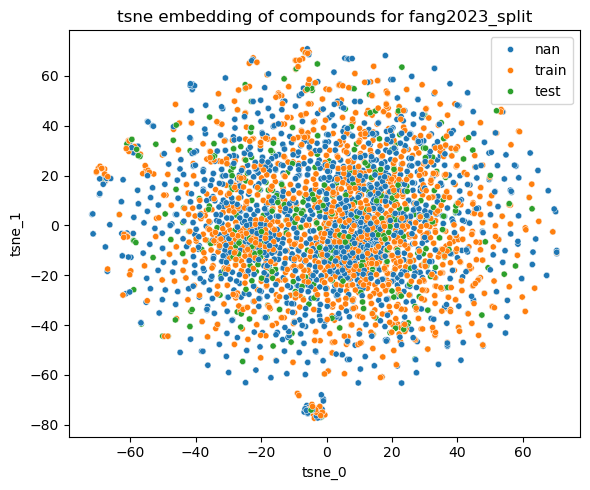

In [31]:
method = "tsne"
fig = display_chemspace(
    data=table.copy(),
    mol_col="smiles",
    split=paper_splits[endpoints[endpoint]],
    split_name="fang2023_split",
    method=method,
    nrows=1,
)
save_figure(
    fig,
    local_path=f"figures/{dataset_name}_{endpoint}_{method}_split.png",
    remote_path=f"{FIGURE_DIR}/{dataset_name}_{endpoint}_{method}_{split_key}.png",
)

The data points in blue can not be found in `gs://polaris-public/Data/ADME/fang2023/MPNN` splitting files.

## Create a Benchmark for Fang et al. 2023 dataset
### The train/test sets are pre-defined from fang et al. 2023 

In [32]:
benchmark_version = "1"

In [33]:
benchmark_path = {}
data_cols = [
    "LOG_HLM_CLint",
    "LOG_RLM_CLint",
    "LOG_MDR1-MDCK_ER",
    "LOG_HPPB",
    "LOG_RPPB",
    "LOG_SOLUBILITY",
]

split_key = "fang2023_split"

benchmark_names = [
    "adme-fang-HCLint", "adme-fang-RCLint","adme-fang-PERM",
    "adme-fang-HPPB", "adme-fang-RPPB", "adme-fang-SOLU"]

for target_col, benchmark_name in zip(data_cols, benchmark_names):
    benchmark_name = f"{benchmark_name}-{benchmark_version}"
    readme_name = f"fang2023_ADME_public_single_reg_{target_col}_v1"
    benchmark = SingleTaskBenchmarkSpecification(
        name=benchmark_name,
        dataset=dataset,
        target_cols=target_col,
        input_cols=["smiles"],
        split=paper_splits[target_col[4:]],
        main_metric="pearsonr",  # fang et al. 2023 use the `pearsonr` for performance evalution
        metrics=[
            "mean_absolute_error",
            "mean_squared_error",
            "r2",
            "spearmanr",
            "pearsonr",
            "explained_var",
        ],
        tags=["adme", "singletask"],
        owner=owner,
        description=f"Single task benchmark for ADME property {target_col}",
        readme=load_readme(
            f"gs://polaris-public/readme/benchmarks/{readme_name}_readme.md"
        ),
    )
    BENCHMARK_SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
    path = benchmark.to_json(BENCHMARK_SAVE_DIR)
    print(path)

gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-HCLint-1/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-RCLint-1/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-PERM-1/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-HPPB-1/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-RPPB-1/benchmark.json
gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-SOLU-1/benchmark.json


## Multitask learning benchmark for all the six ADME endpoints which share one train/test split. 

In [35]:
# regression
TEST_SIZE = 0.2
SEED = 111

# random split
random_splitter = ShuffleSplit(n_splits=5, test_size=TEST_SIZE, random_state=SEED)
random_split = next(random_splitter.split(X=dataset.table.smiles.values))
split_key = "random"

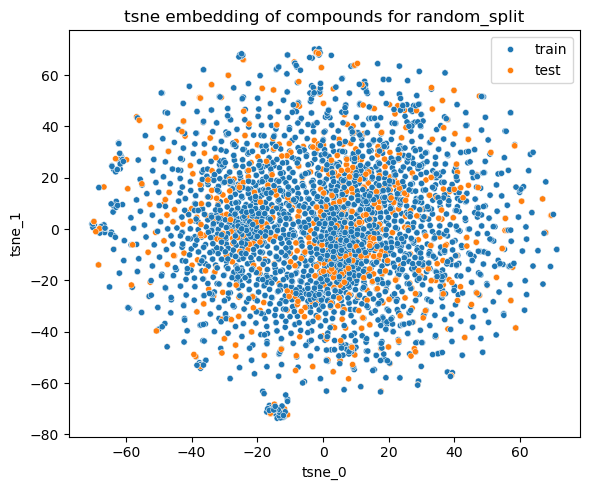

In [36]:
data_name = "adme-fang-1"
method = "tsne"
split_key = "random_split"
fig = display_chemspace(
    data=table,
    mol_col="smiles",
    split=random_split,
    split_name=split_key,
    method=method,
)
save_figure(
    fig,
    local_path=f"figures/{data_name}_{method}_split.png",
    remote_path=f"{FIGURE_DIR}/{data_name}_{method}_{split_key}.png",
)

In [37]:
benchmark_name = f"adme-fang-r-{benchmark_version}"
readme_name = f"fang2023_ADME_public_multitask_reg_v{benchmark_version}"

In [38]:
benchmark_multi = MultiTaskBenchmarkSpecification(
    name=benchmark_name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=random_split,
    tags=["adme", "multitask"],
    owner=owner,
    description="A multitask benchmark for six ADME endpoints, utilizing a shared random split. ",
    main_metric="mean_squared_error",
    metrics=[
        "mean_absolute_error",
        "mean_squared_error",
        "r2",
        "spearmanr",
        "pearsonr",
        "explained_var",
    ],
    readme=load_readme(
        f"gs://polaris-public/readme/benchmarks/{readme_name}_readme.md"
    ),
)
SAVE_DIR = f"{BENCHMARK_DIR}/{benchmark_name}"
path = benchmark_multi.to_json(SAVE_DIR)
print(path)

gs://polaris-public/benchmarks/ADME/fang2023/adme-fang-r-1/benchmark.json
